# **Exploring data for each cluster**

**Importing modules + dataframes**

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mp_api.client import MPRester
from pymatgen.analysis.pourbaix_diagram import PourbaixDiagram
from pymatgen.analysis.pourbaix_diagram import PourbaixPlotter
from IPython.display import display
import random 

# Importing all datasets
cluster_1 = pd.read_csv(r'Cluster_csv_files\Cluster_0.csv')
cluster_2 = pd.read_csv(r'Cluster_csv_files\Cluster_1.csv')
cluster_3 = pd.read_csv(r'Cluster_csv_files\Cluster_2.csv')
cluster_4 = pd.read_csv(r'Cluster_csv_files\Cluster_3.csv')
cluster_5 = pd.read_csv(r'Cluster_csv_files\Cluster_4.csv')

**Determining which cluster is assigned**

In [29]:
#Function to find minimum overpotential in a dataset
def print_min(data):
    print(data["Overpotential at xx (nearby) current density vs RHE, V"].min())
print_min(cluster_1)
print_min(cluster_2)
print_min(cluster_3)
print_min(cluster_4)
print_min(cluster_5)
df_list = [cluster_1,cluster_2,cluster_3,cluster_4,cluster_5]

0.81
1.89
1.09
0.26
1.36


In [30]:
# Assigning clusters

def assign_clusters(df_list):
    for data in df_list:
        if data["Overpotential at xx (nearby) current density vs RHE, V"].min() == 1.89:
            left_data = data
        elif data["Overpotential at xx (nearby) current density vs RHE, V"].min() == 1.09:
            middle_left = data
        elif data["Overpotential at xx (nearby) current density vs RHE, V"].min() == 0.81:
            middle_right = data
        elif data["Overpotential at xx (nearby) current density vs RHE, V"].min() == 0.26:
            optimum_region = data
        else:
            right_data = data
    new_df_list = [left_data,middle_left,middle_right,optimum_region,right_data]
    return new_df_list

new_df_list = assign_clusters(df_list)
#print(new_df_list)

var_names = ["left_data", "middle_left", "middle_right", "optimum_region", "right_data"]
vars_dict = dict(zip(var_names, new_df_list))
left_data = vars_dict["left_data"]
middle_left= vars_dict["middle_left"]
middle_right = vars_dict["middle_right"]
optimum_region = vars_dict["optimum_region"]
right_data = vars_dict["right_data"]

In [31]:
#Making a spreadsheet for each region
with pd.ExcelWriter('separated regions.xlsx') as writer:  
    left_data.to_excel(writer, sheet_name='left data')
    middle_right.to_excel(writer, sheet_name='middle right')
    middle_left.to_excel(writer, sheet_name='middle left')
    optimum_region.to_excel(writer, sheet_name='optimum region')
    right_data.to_excel(writer, sheet_name='right data')

**Finding composition data on each dataframe**

In [44]:
#Function to produce a df of counts for every element within each datafram
def retrieve_composition_df(df):
    comp_list = list(df['composition'])
    ind_element = []
    for i in comp_list:
        ind_element+=i.split()
    [[x,ind_element.count(x)] for x in set(ind_element)]
    ind_element_dic =  dict((x,ind_element.count(x)) for x in set(ind_element))
    ind_element_df = pd.DataFrame.from_dict(ind_element_dic, orient = 'index', columns=['Count'])
    ind_element_df= ind_element_df.reset_index(names=['Element'])
    ind_element_df = ind_element_df.sort_values(by = 'Count', ascending=False, ignore_index=True)
    return ind_element_df


In [45]:
#Bar chart plot to visualise the number of elements in each region, +saving figures
def bar_chart_element_count(df1,df2,df3,df4,df5):
    df_list = [df1,df2,df3,df4,df5]
    for i in range(0,len(df_list)):
        title_lst = ['Optimum region','Left side','Middle left','Middle right', 'Right side']
        df = df_list[i].loc[1:12,:]
        df = df[df.Element != 'O2']
        fig, ax = plt.subplots()
        ax.bar(x=df['Element'], height=df['Count'])
        ax.set_title(title_lst[i])
        ax.set_xlabel('Element')
        ax.set_ylabel('Count')
        fig.savefig('Bar_charts\\'+title_lst[i]+'.png', bbox_inches='tight')


In [47]:

element_df_optimum =  retrieve_composition_df(optimum_region)
element_df_left =  retrieve_composition_df(left_data)
element_df_middle_left =  retrieve_composition_df(middle_left)
element_df_middle_right =  retrieve_composition_df(middle_right)
element_df_right =  retrieve_composition_df(right_data)
#bar_chart_element_count(element_df_optimum,element_df_left,element_df_middle_left,element_df_middle_right,element_df_right)

**Analysing if elements are spread or concentrated in one region**

In [ ]:
#Adding new column names
title_lst = ['Optimum region','Left side','Middle left','Middle right', 'Right side']
element_df_optimum['Region'] = 'Optimum region'
element_df_left['Region'] = 'Left side'
element_df_middle_left['Region'] =  'Middle left'
element_df_middle_right['Region'] = 'Middle right'
element_df_right['Region'] = 'Right side'

In [ ]:
#Combining datasets 
combined_element_df = pd.concat([element_df_optimum,element_df_left,element_df_middle_left,element_df_middle_right,element_df_right])
combined_element_df = combined_element_df.pivot_table(
                        values='Count',
                        index='Element',
                        columns='Region',
                        fill_value=0,
                        aggfunc= sum,
                        margins=True)
#combined_element_df.to_excel('Element analysis file.xlsx')

In [ ]:
# Function to remove rows which will not get us data from the materials project
def remove_rows_without_data(datset):
    df = datset.dropna(subset = ['material id'], inplace = False)
    return df
df_list = [optimum_region,middle_left,middle_right,left_data,right_data]
left_data_pourbaix = remove_rows_without_data(left_data)
right_data_pourbaix = remove_rows_without_data(right_data)
middle_left_pourbaix = remove_rows_without_data(middle_left)
middle_right_pourbaix = remove_rows_without_data(middle_right)
optimum_region_pourbaix = remove_rows_without_data(optimum_region)

**Code for Generating pourbaix diagrams**

In [ ]:
#Function to generate a pourbaix diagram

def generate_pourbaix(chemsys,path):
    with MPRester(api_key='CmGarHKLtPCjVpEkivPDYkhRJKJiB8A7') as mpr:
        pourbaix_entries = mpr.get_pourbaix_entries(chemsys)
    pd = PourbaixDiagram(pourbaix_entries)
    plotter = PourbaixPlotter(pd)
    PourbaixPlotter.get_pourbaix_plot(plotter,limits=[[-2, 16],[-3, 3]]) # Typical value for lower = -2, upper = 16
    #plt.savefig(path+chemsys+'.png',bbox_inches='tight')

**Gathering 10 random samples from each region**

In [ ]:
#Finding 10 random formulas from each region
# rand_opt_region = random.sample(list(optimum_region_pourbaix['chemsys']), 10)
# rand_middle_left = random.sample(list(middle_left_pourbaix['chemsys']), 10)
# rand_middle_right = random.sample(list(middle_right_pourbaix['chemsys']), 10)
# rand_left = random.sample(list(left_data_pourbaix['chemsys']), 10)
# rand_right = random.sample(list(right_data_pourbaix['chemsys']), 10)

rand_opt_region = ['Cd-Mn-O', 'O-Rh-Tb', 'Lu-Mn-O', 'Fe-Lu-O', 'La-O-Ti', 'Ba-Mn-O', 'Cr-O-Sr', 'Ca-O-Ru', 'Mn-Nd-O', 'Fe-Nd-O']
rand_middle_left = ['Cr-Ho-O', 'O-Pb-V', 'Na-O-Pu', 'Dy-O-V', 'K-O-Os', 'Nb-O-Yb', 'La-O-Ta', 'O-Sm-V', 'Cd-O-V', 'K-O-Ta']
rand_middle_right = ['Bi-Ho-O', 'Ba-Bi-O', 'Ho-Ni-O', 'Cu-La-O', 'Au-Ba-O', 'Cs-I-O', 'Lu-Ni-O', 'Al-O-Yb', 'Dy-Ni-O', 'Ba-Cu-O']
rand_left = ['Ba-Mo-O', 'In-O-Ta', 'Na-O-W', 'Ca-O-W', 'Al-Ba-O', 'O-Tl-W', 'Ba-Nb-O', 'O-Sc-Si', 'Mo-Na-O', 'O-Sr-V']
rand_right = ['Al-Gd-O', 'Ba-O-Zr', 'O-Sr-Ti', 'O-Sc-Yb', 'Ba-O-Sc', 'In-Nd-O', 'Cu-O-Y', 'O-Pb-Sr', 'Eu-Ge-O', 'Ba-In-O']

#Function to generate pourbaix diagrams through each list
def list_screening(lst,index):
    path_name = ['Pourbaix_plots\Optimum_region\\','Pourbaix_plots\Middle_left\\','Pourbaix_plots\Middle_right\\',
                'Pourbaix_plots\Left_data\\','Pourbaix_plots\Right_data\\']
    for i in range(0,len(lst)):
        generate_pourbaix(lst[i],path_name[index])

In [ ]:
# Generating pourbaix diagrams for random elements selected
# print(rand_opt_region)
# print(rand_middle_left)
# print(rand_middle_right)
# print(rand_left)
# print(rand_right)

#list_screening(rand_opt_region,0)
#list_screening(rand_middle_left,1)
# list_screening(rand_middle_right,2)
# list_screening(rand_left,3)
# list_screening(rand_right,4)

**Comparing single element pourbaix to multi element**

Retrieving ThermoDoc documents: 100%|██████████| 113/113 [00:00<?, ?it/s]


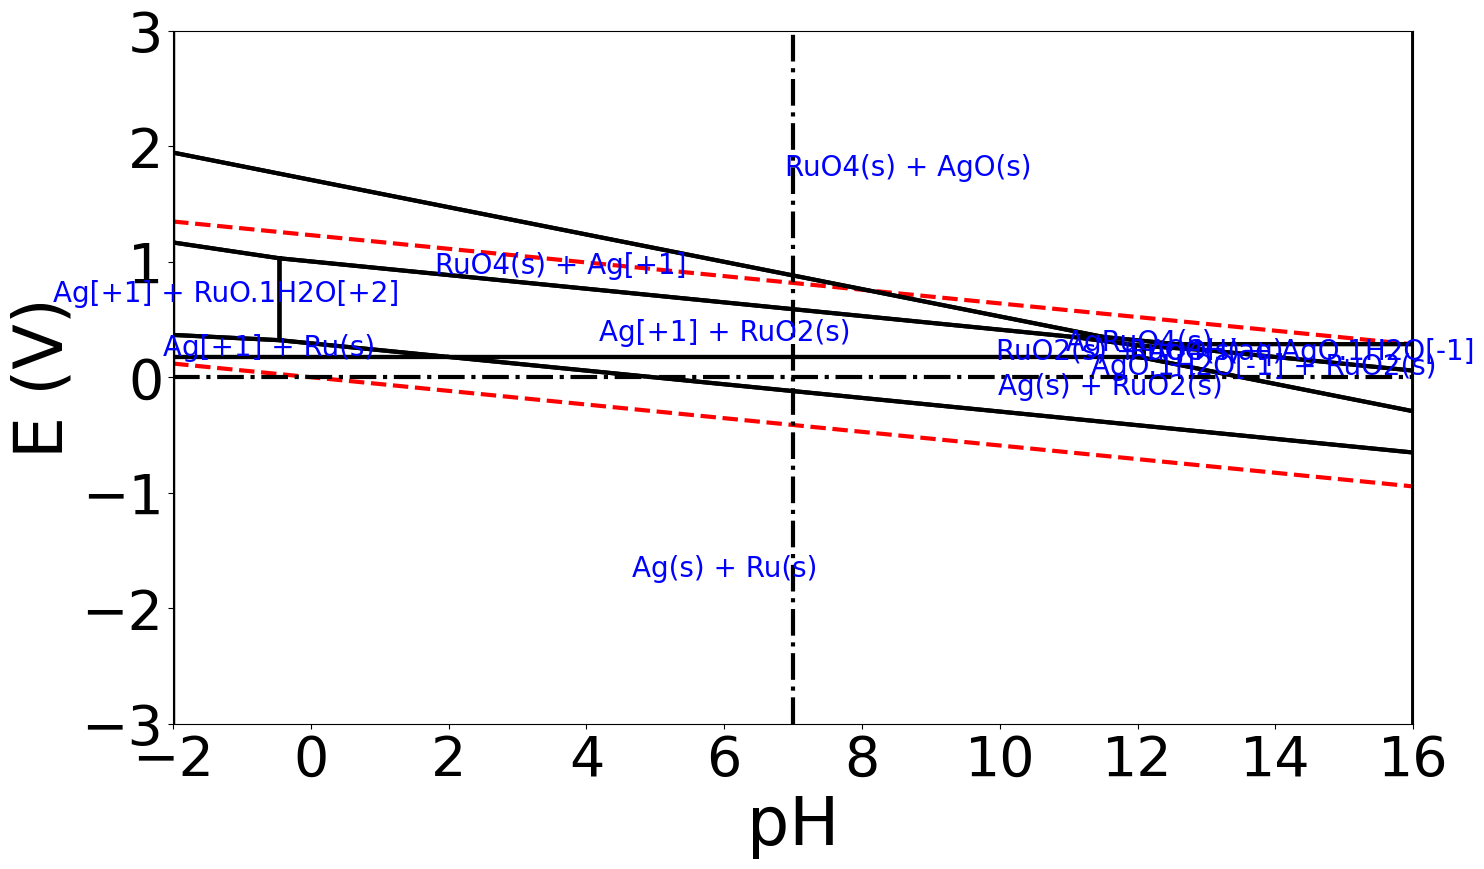

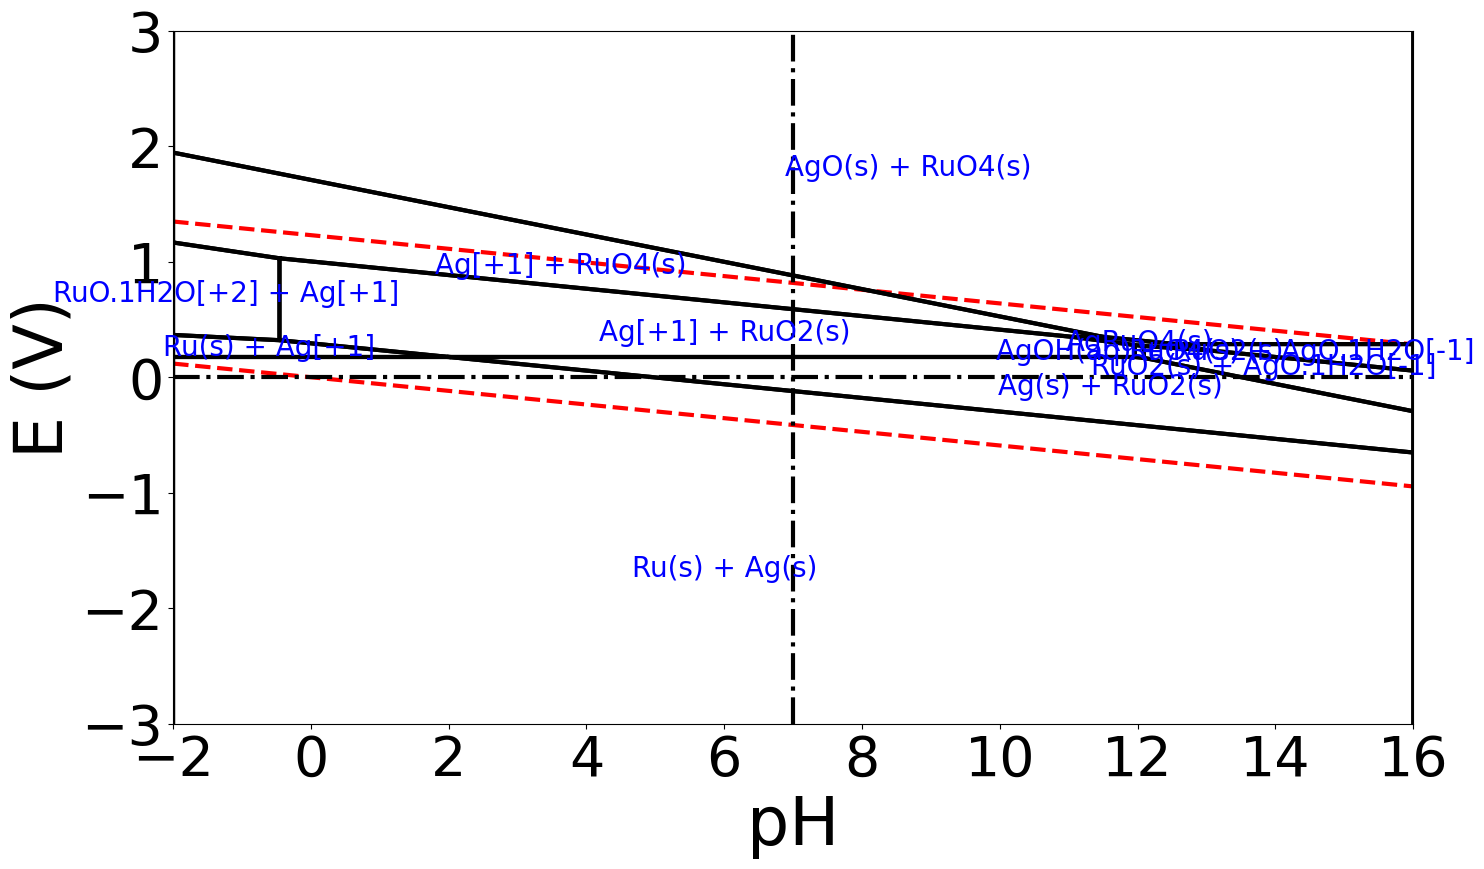

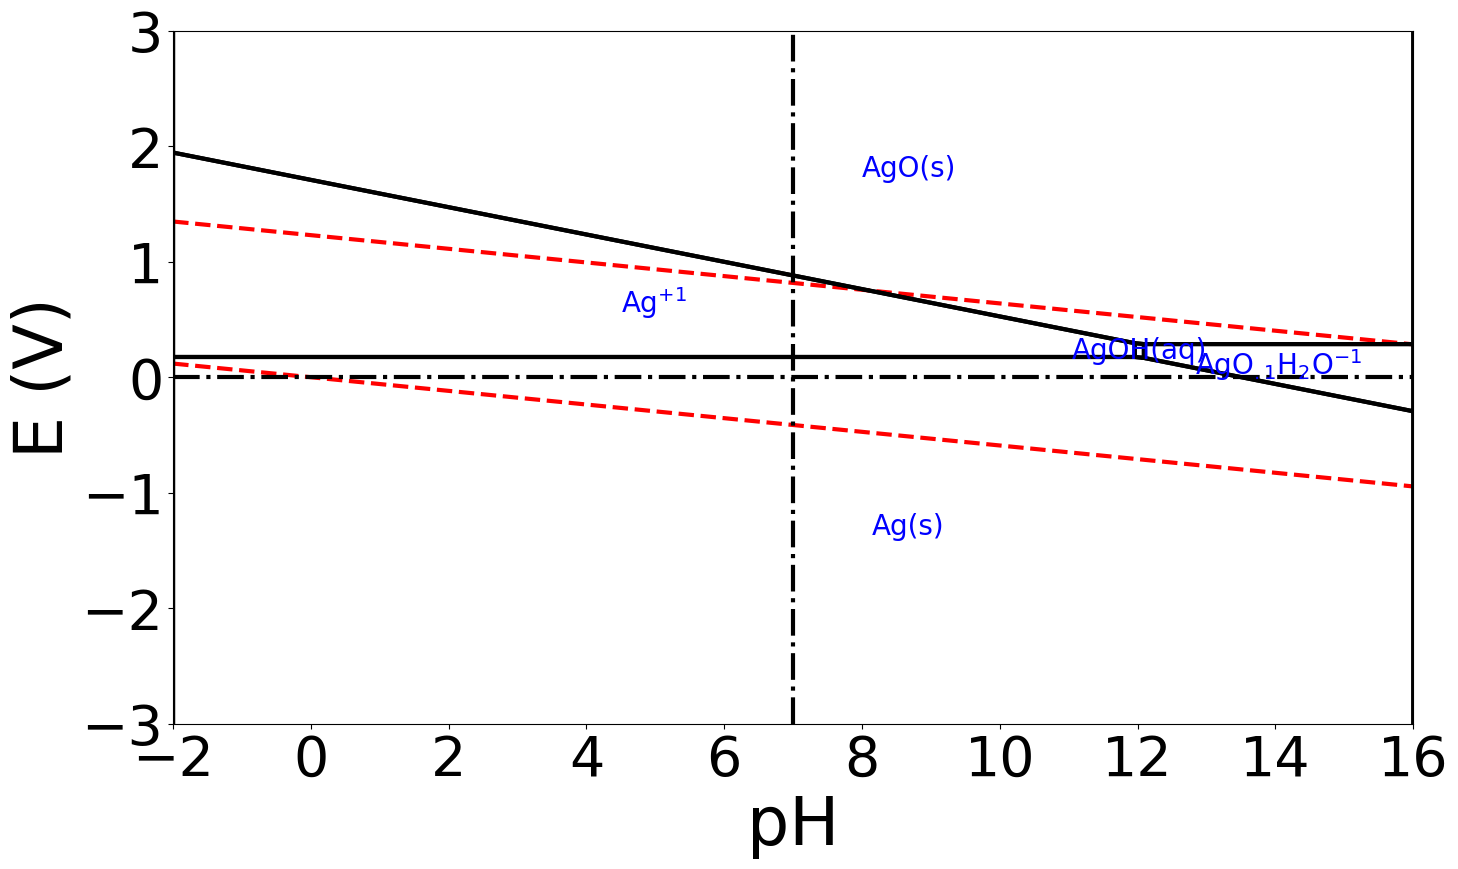

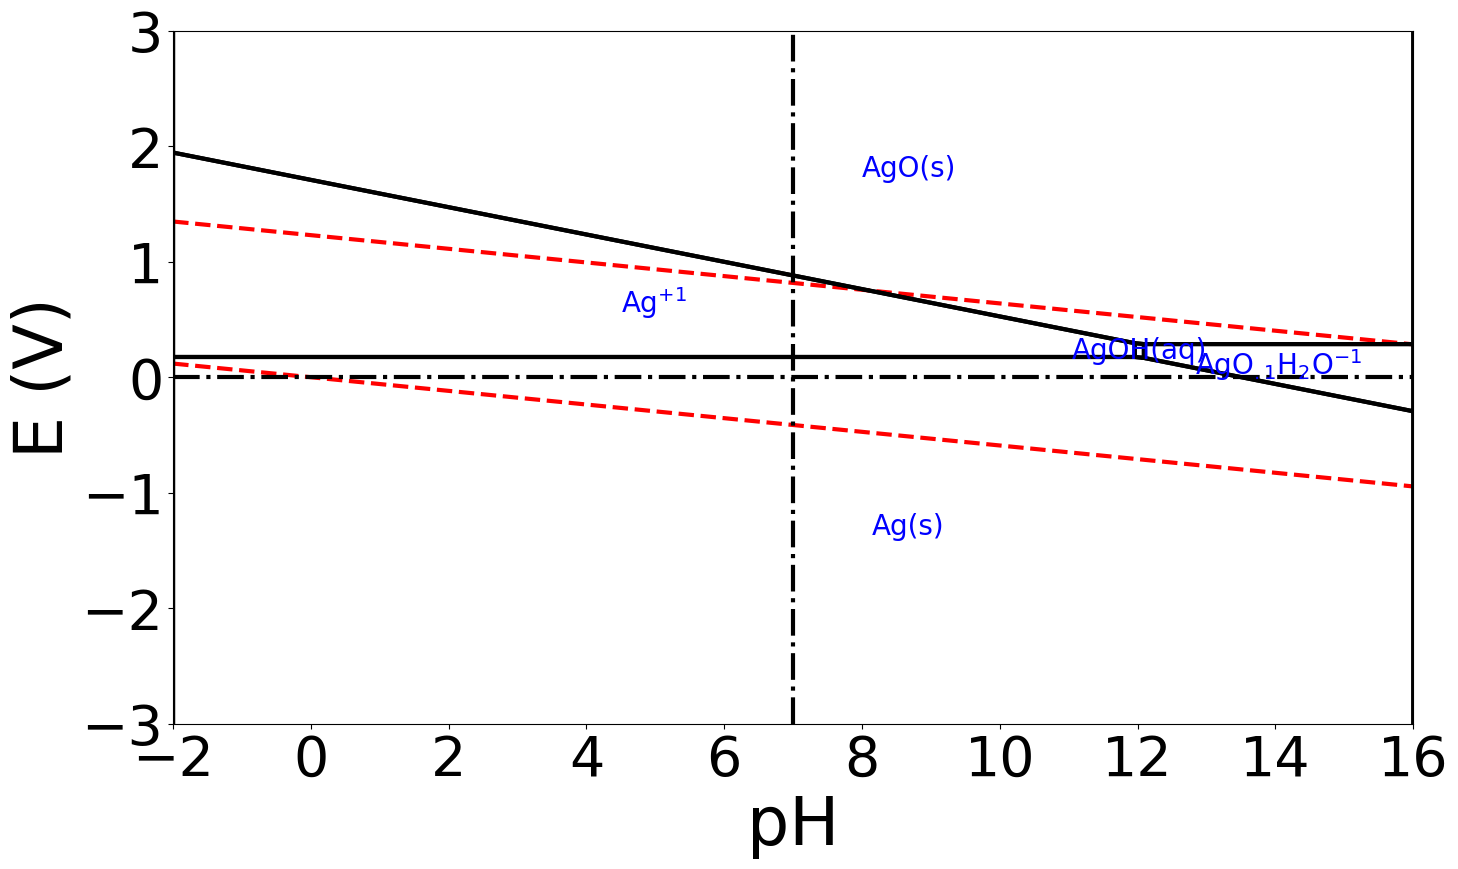

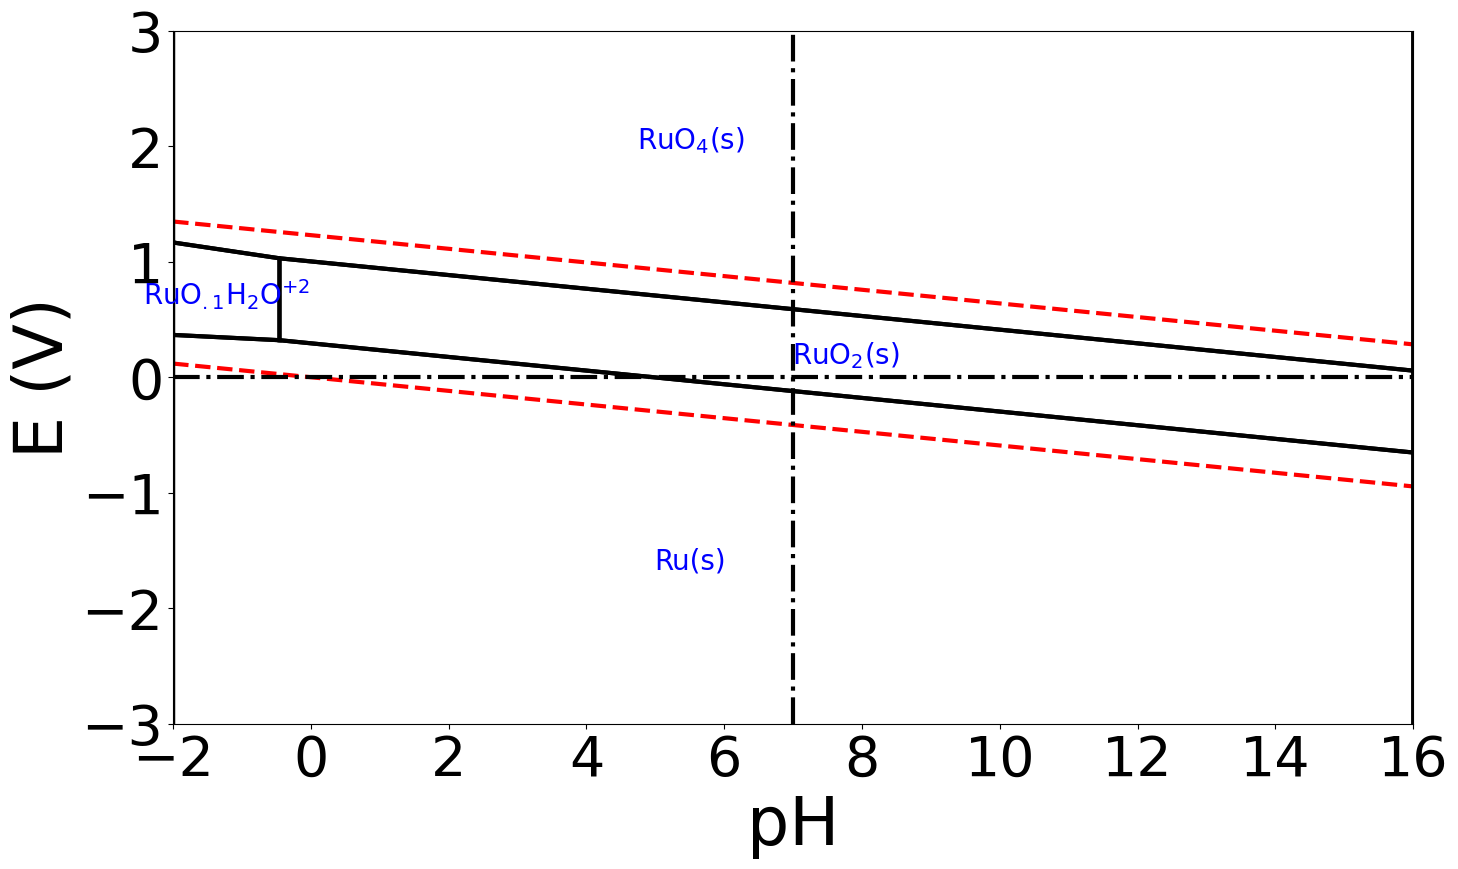

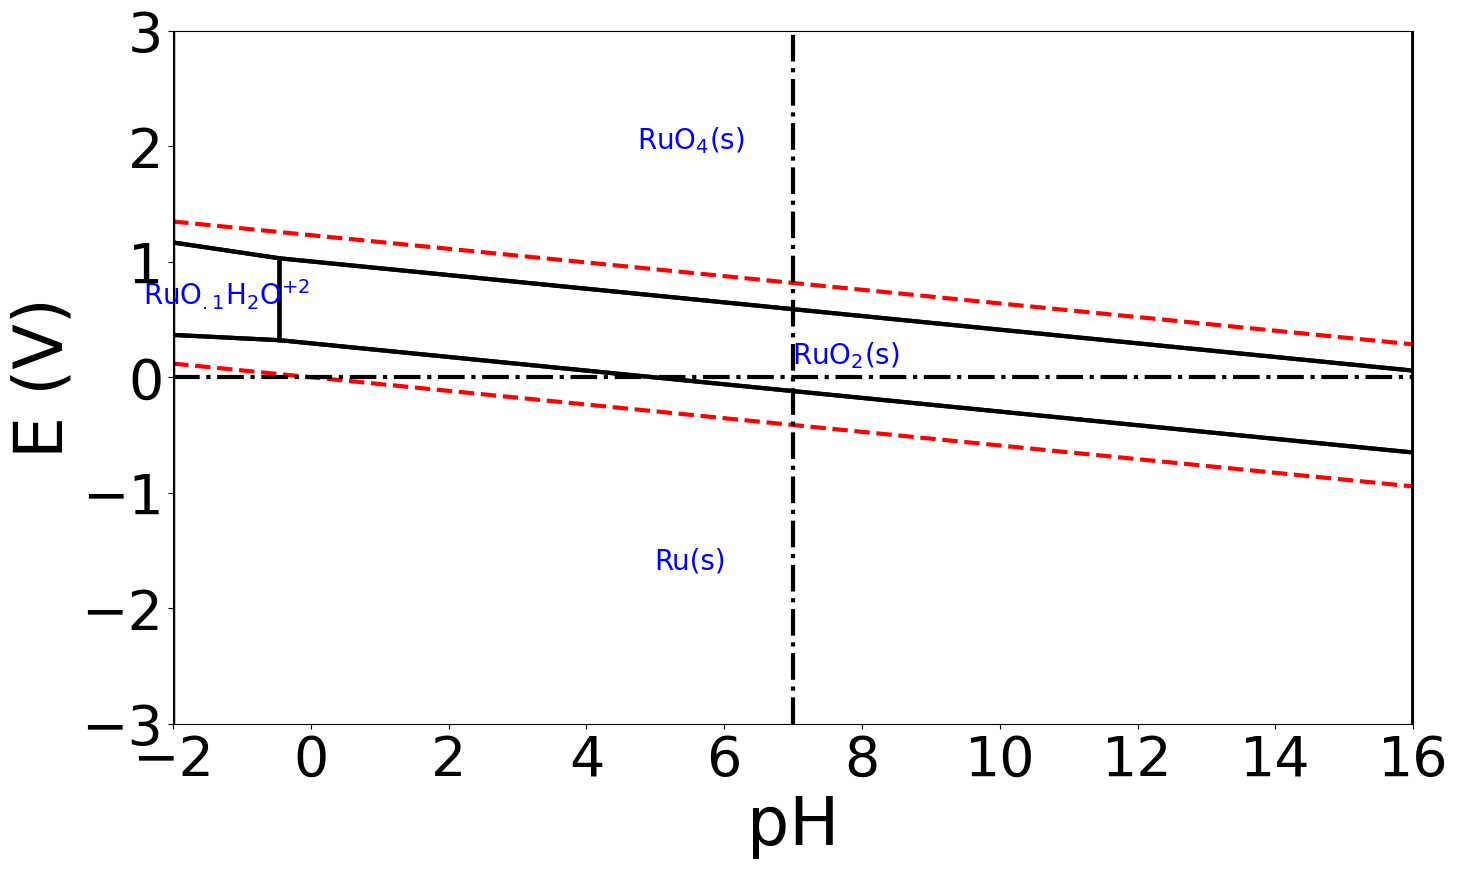

In [ ]:
# This cell will focus on the effects of noble metals

generate_pourbaix('Ag-Ru-O',0)
generate_pourbaix('Ag-Ru',0)
generate_pourbaix('Ag',0)
generate_pourbaix('Ag-O',0)
generate_pourbaix('Ru',0)
generate_pourbaix('Ru-O',0)


Retrieving ThermoDoc documents: 100%|██████████| 158/158 [00:00<?, ?it/s]


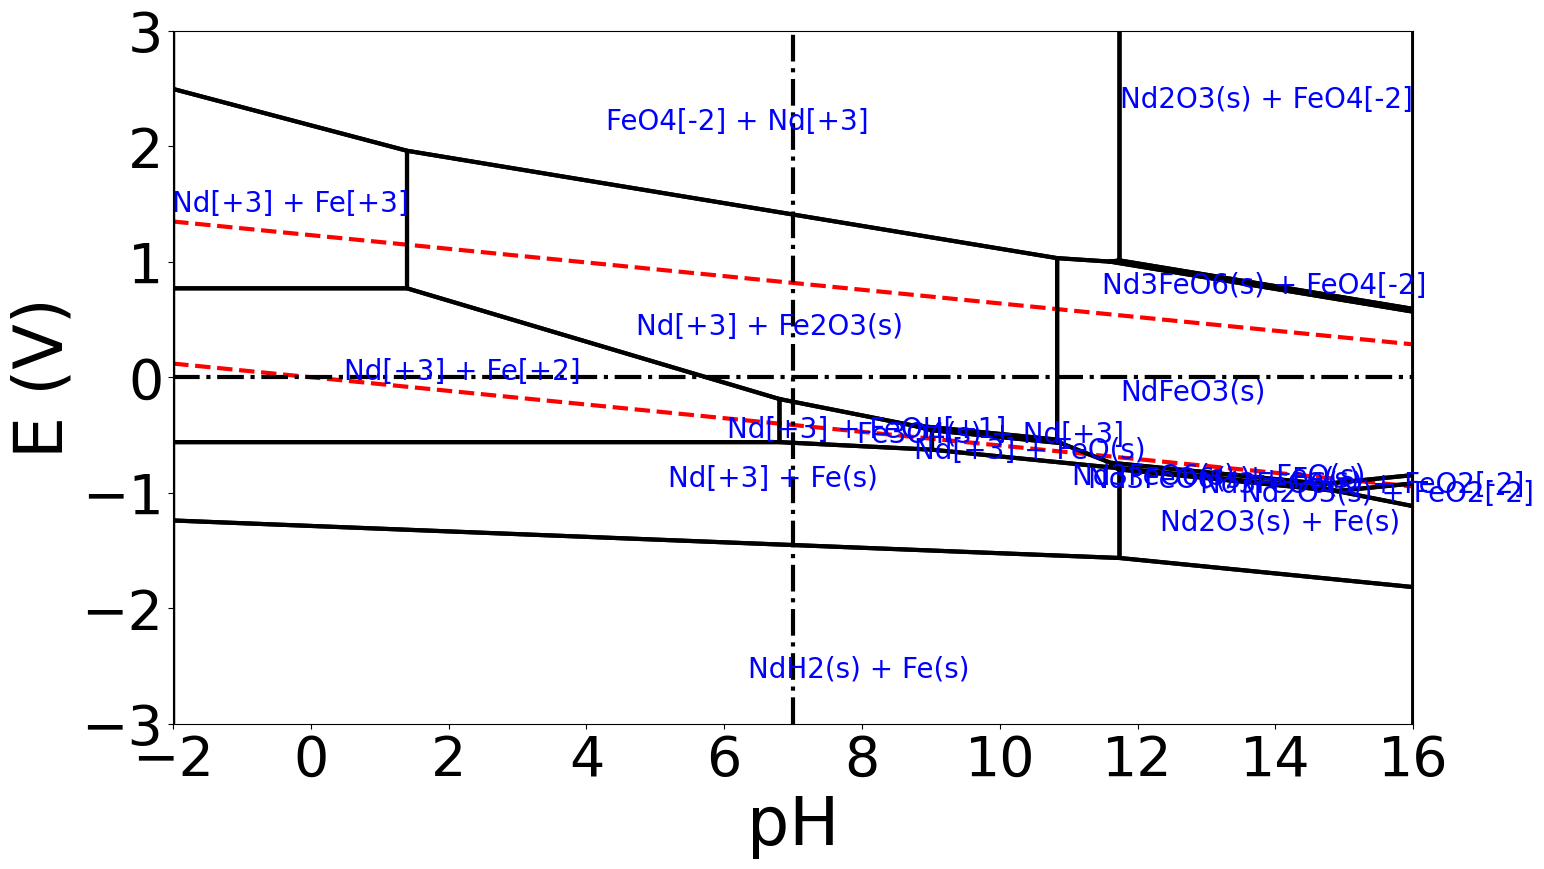

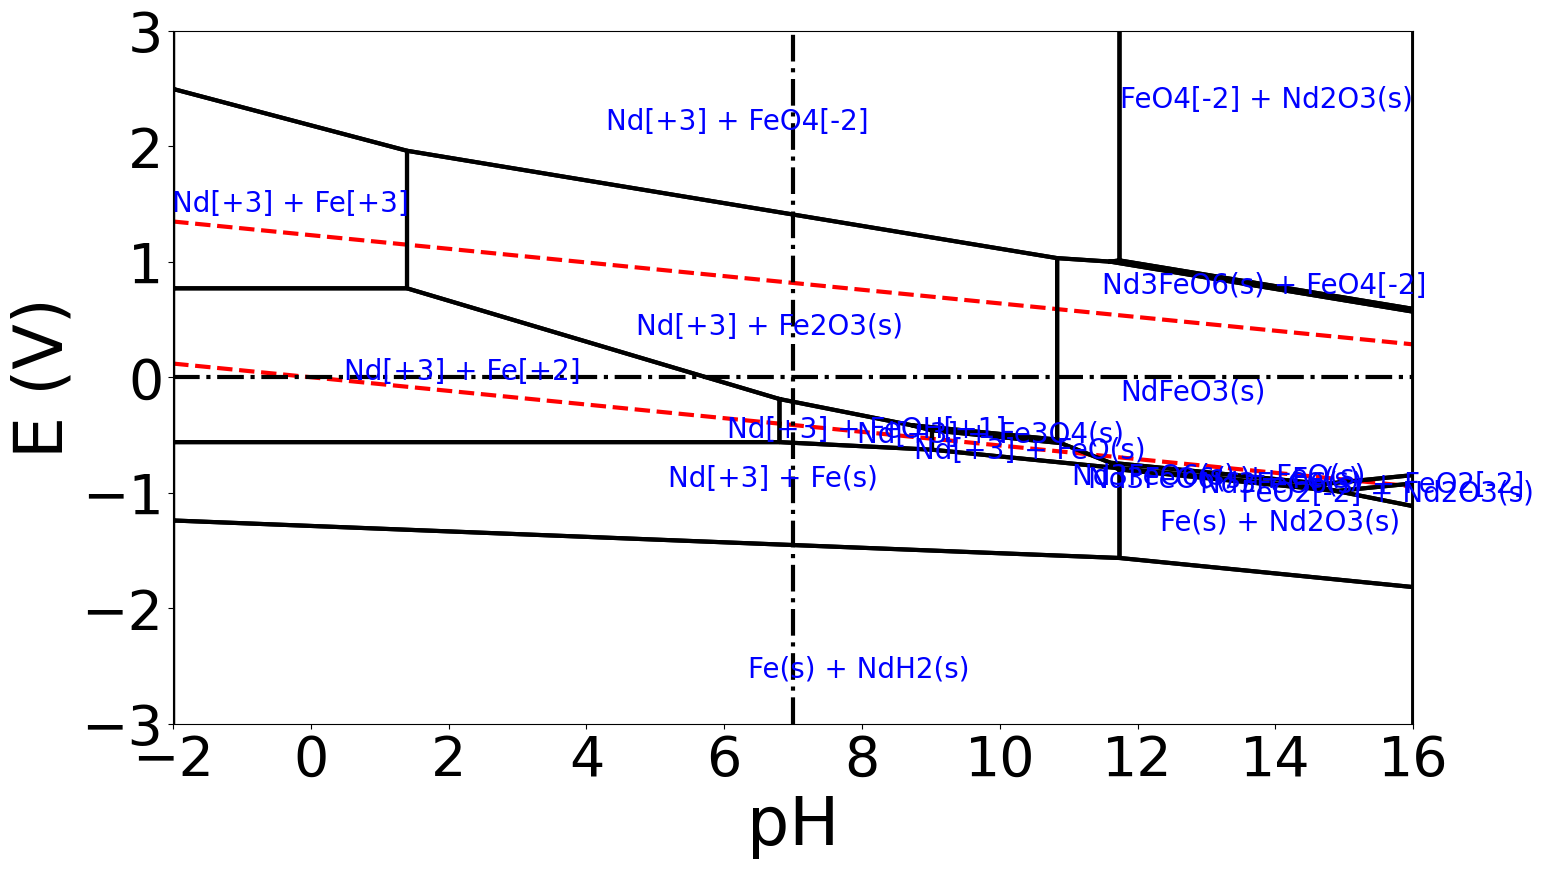

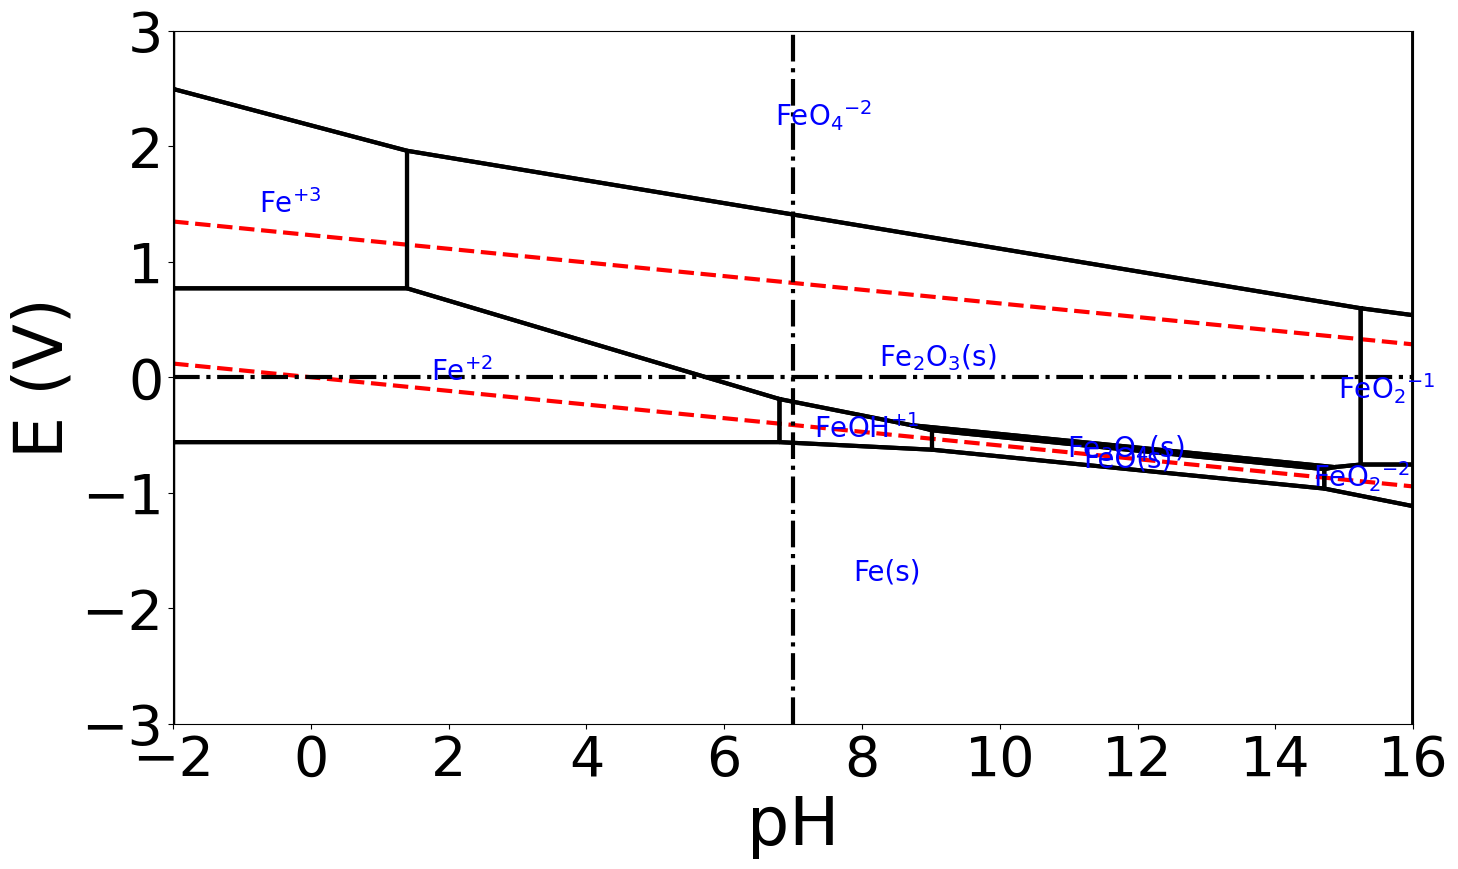

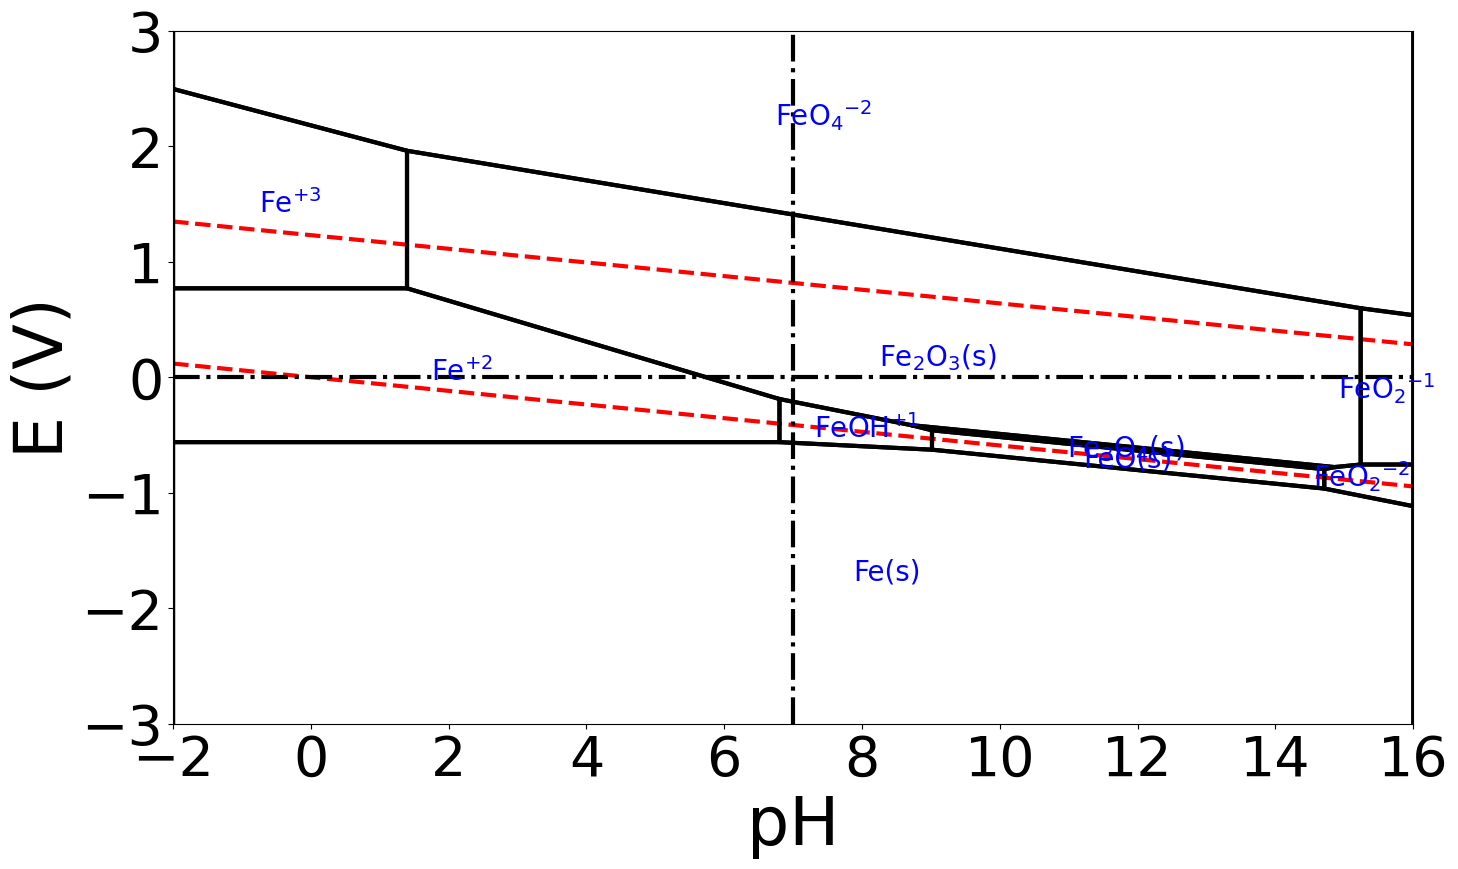

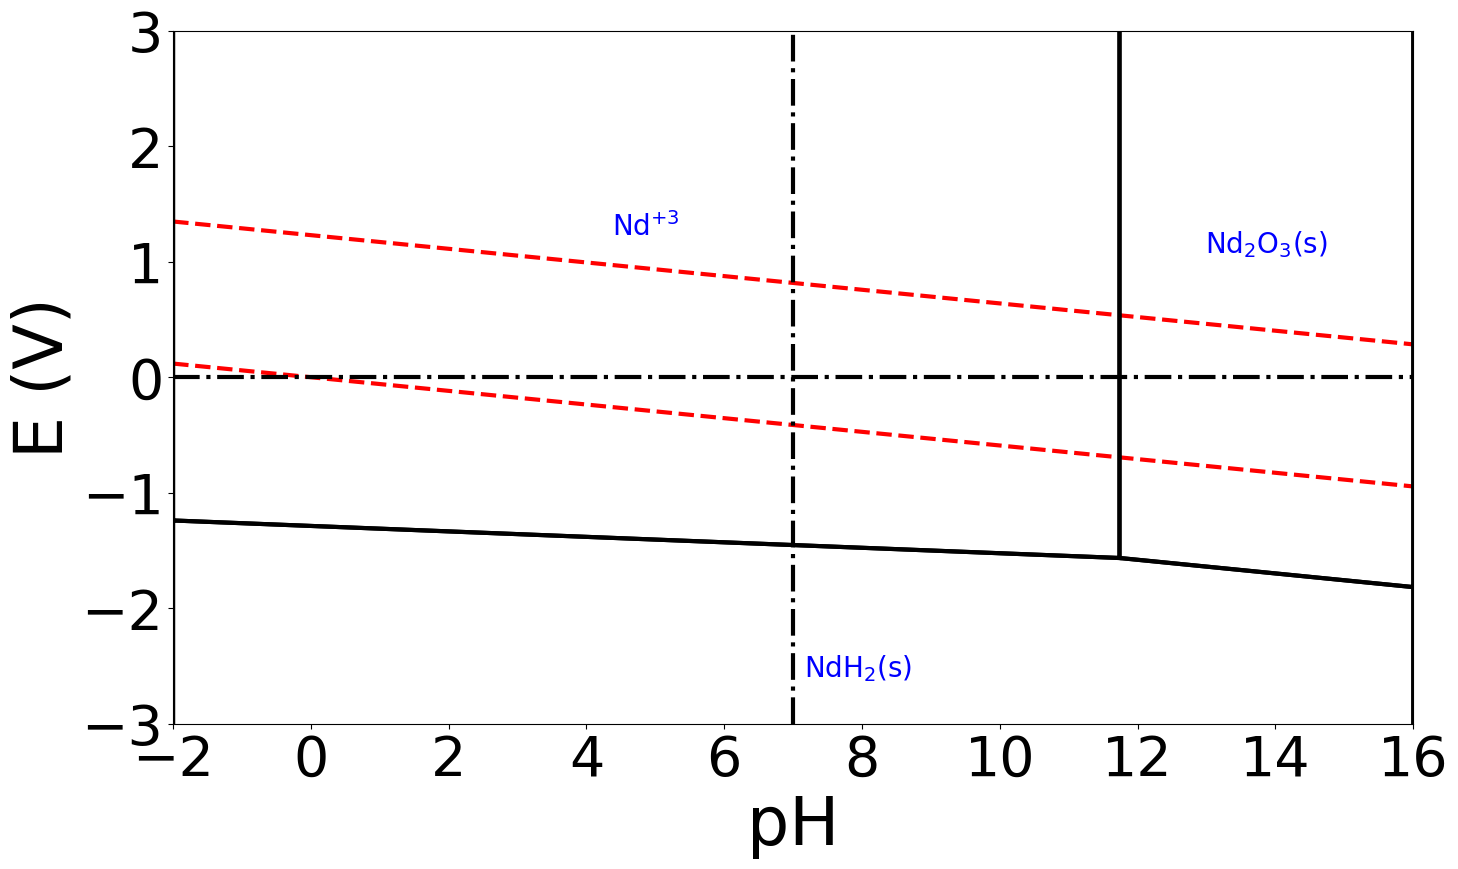

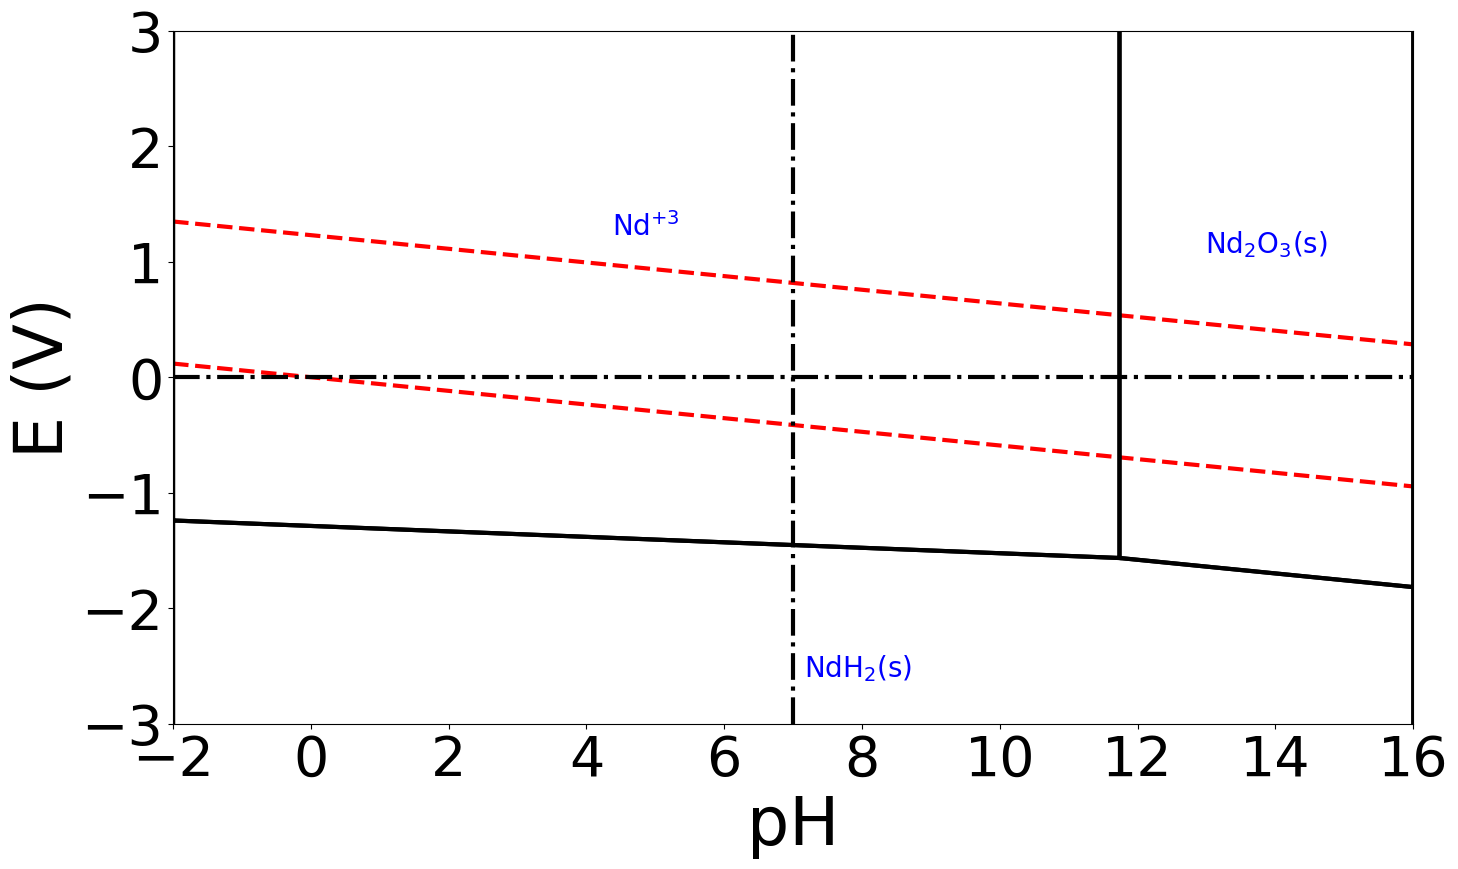

In [ ]:
# This cell will focus on the effects of lanthanides

generate_pourbaix('Fe-Nd-O',0)
generate_pourbaix('Fe-Nd',0)
generate_pourbaix('Fe',0)
generate_pourbaix('Fe-O',0)
generate_pourbaix('Nd',0)
generate_pourbaix('Nd-O',0)
